<a href="https://colab.research.google.com/github/singh-mir-ror/Dashtoon-Assignment/blob/main/22566008_Dashtoon_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
img_dir = '/tmp/nst'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg

### Import and configure modules

In [38]:

from PIL import Image

#function to resize the downloaded images to 512x512 for our style transfer function to work
def resize_images(input_folder, output_folder, size):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith(('.jpg', '.png', '.jpeg')):  # Adjust for other image formats if needed
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            original_image = Image.open(input_path)
            resized_image = original_image.resize(size)
            resized_image.save(output_path)


input_directory = "/content"
output_directory = "/content/Content"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
target_size = (256, 256)

resize_images(input_directory, output_directory, target_size)

In [39]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

In [40]:
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [41]:

import tensorflow as tf

from tensorflow.keras.utils import image_dataset_from_directory as kp_image
from tensorflow.python.keras import models
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [43]:

import os
from PIL import Image

directory_path = "/content"

image_files = [f for f in os.listdir(directory_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

images = []

for image_file in image_files:
    image_path = os.path.join(directory_path, image_file)
    img = Image.open(image_path)
    images.append(img)

In [7]:
# for Jupyter execute this
'''
import os

directory_path = '/path/to/your/directory'
c_image_path = 'image1.jpg'
s_image_path='image_2.jpg'

content_path = os.path.join(directory_path, c_image_path)
style_path = os.path.join(directory_path, s_image_path)
'''

"\nimport os\n\ndirectory_path = '/path/to/your/directory'\nc_image_path = 'image1.jpg'\ns_image_path='image_2.jpg'\n\ncontent_path = os.path.join(directory_path, c_image_path)\nstyle_path = os.path.join(directory_path, s_image_path)\n"

In [31]:
# for Colab File execute this
content_path = '/content/content_1.jpeg'
style_path = '/content/Style/style.jpg'

## Visualize the input

These are input content and style images. We hope to "create" an image with the content of our content image, but with the style of the style image.

<ipython-input-9-82922293385f>:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((round(img.size[0] * scale), round(img.size[1] * scale)), Image.ANTIALIAS)


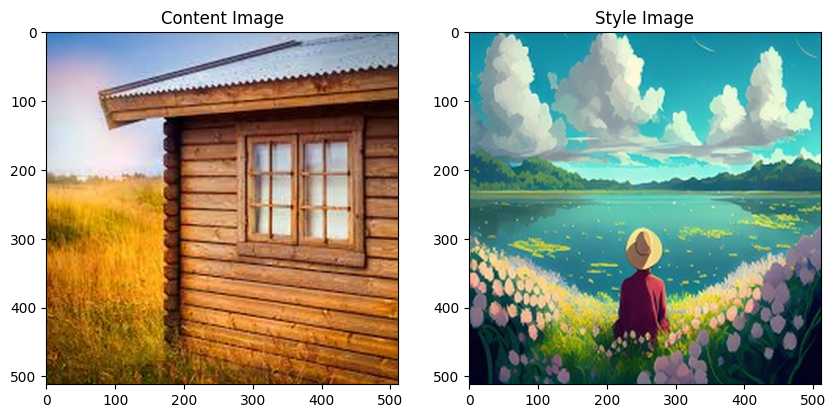

In [9]:
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def load_img(path_to_img):
    max_dim = 512
    img = Image.open(path_to_img)
    long = max(img.size)
    scale = max_dim / long
    img = img.resize((round(img.size[0] * scale), round(img.size[1] * scale)), Image.ANTIALIAS)

    img = image.img_to_array(img)  # Use image.img_to_array from Keras

    # We need to broadcast the image array such that it has a batch dimension
    img = np.expand_dims(img, axis=0)
    return img

def imshow(img, title=None):
    # Remove the batch dimension
    out = np.squeeze(img, axis=0)
    # Normalize for display
    out = out.astype('uint8')
    plt.imshow(out)
    if title is not None:
        plt.title(title)

plt.figure(figsize=(10, 10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

In [10]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [11]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")

  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [12]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2']

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [13]:
def get_model():
  """ Creates our model with access to intermediate layers.

  This function will load the VGG19 model and access the intermediate layers.
  These layers will then be used to create a new model that will take input image
  and return the outputs from these intermediate layers from the VGG model.

  Returns:
    returns a keras model that takes image inputs and outputs the style and
      content intermediate layers.
  """
  # Load our model. We load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  # Get output layers corresponding to style and content layers
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model
  return models.Model(vgg.input, model_outputs)

## Define and create our loss functions (content and style distances)

In [14]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

## Style Loss

### Computing style loss
Again, we implement our loss as a distance metric .

In [15]:
def gram_matrix(input_tensor):
  # We make the image channels first
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  """Expects two images of dimension h, w, c"""
  # height, width, num filters of each layer
  # We scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)

  return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

## Apply style transfer to our images


We’ll define a little helper function that will load our content and style image, feed them forward through our network, which will then output the content and style feature representations from our model.

In [16]:
def get_feature_representations(model, content_path, style_path):
  """Helper function to compute our content and style feature representations.

  This function will simply load and preprocess both the content and style
  images from their path. Then it will feed them through the network to obtain
  the outputs of the intermediate layers.

  Arguments:
    model: The model that we are using.
    content_path: The path to the content image.
    style_path: The path to the style image

  Returns:
    returns the style features and the content features.
  """
  # Load our images in
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)

  # batch compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)


  # Get the style and content feature representations from our model
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

In [17]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  """This function will compute the loss total loss.

  Arguments:
    model: The model that will give us access to the intermediate layers
    loss_weights: The weights of each contribution of each loss function.
      (style weight, content weight, and total variation weight)
    init_image: Our initial base image. This image is what we are updating with
      our optimization process. We apply the gradients wrt the loss we are
      calculating to this image.
    gram_style_features: Precomputed gram matrices corresponding to the
      defined style layers of interest.
    content_features: Precomputed outputs from defined content layers of
      interest.

  Returns:
    returns the total loss, style loss, content loss, and total variational loss
  """
  style_weight, content_weight = loss_weights

  # Feed our init image through our model. This will give us the content and
  # style representations at our desired layers. Since we're using eager
  # our model is callable just like any other function!
  model_outputs = model(init_image)

  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]

  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)

  # Accumulate content losses from all layers
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)

  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score
  return loss, style_score, content_score

Then computing the gradients is easy:

In [18]:
def compute_grads(cfg):
  with tf.GradientTape() as tape:
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

### Optimization loop

In [19]:
import IPython.display

def run_style_transfer(content_path,
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3,
                       style_weight=1e-2):
  # We don't need to (or want to) train any layers of our model, so we set their
  # trainable to false.
  model = get_model()
  for layer in model.layers:
    layer.trainable = False

  # Get the style and content feature representations (from our specified intermediate layers)
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = tf.optimizers.Adam(learning_rate=5, epsilon=1e-1)

  # For displaying intermediate images
  iter_count = 1

  # Store our best result
  best_loss, best_img = float('inf'), None

  # Create a nice config
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }

  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()

  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means

  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time()

    if loss < best_loss:
      # Update best loss and best image from total loss.
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()

      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))
      print('Total loss: {:.4e}, '
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])

  return best_img, best_loss

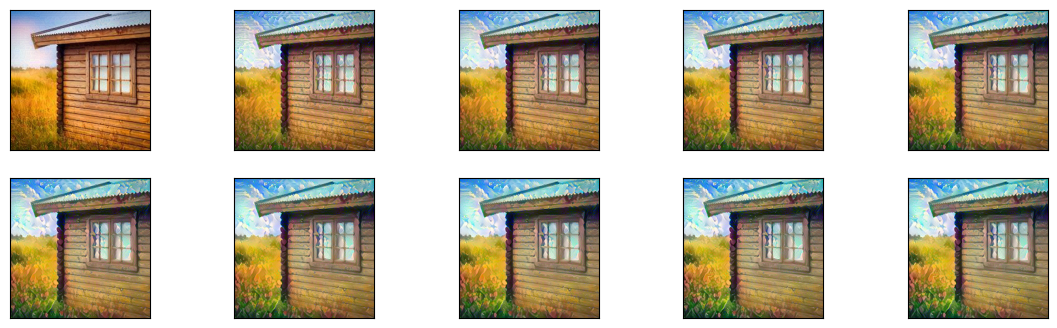

In [20]:
best, best_loss = run_style_transfer(content_path,
                                     style_path, num_iterations=1000)

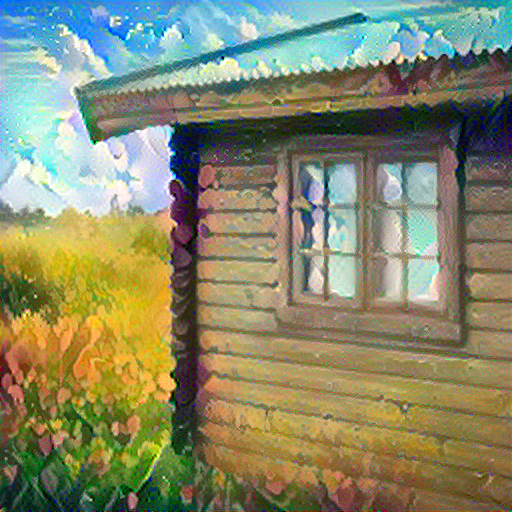

In [21]:
Image.fromarray(best)

## Visualize outputs
We "deprocess" the output image in order to remove the processing that was applied to it.

<ipython-input-9-82922293385f>:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((round(img.size[0] * scale), round(img.size[1] * scale)), Image.ANTIALIAS)


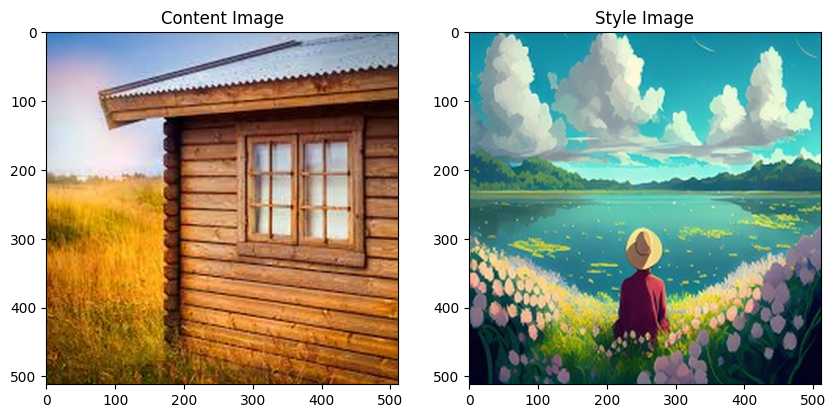

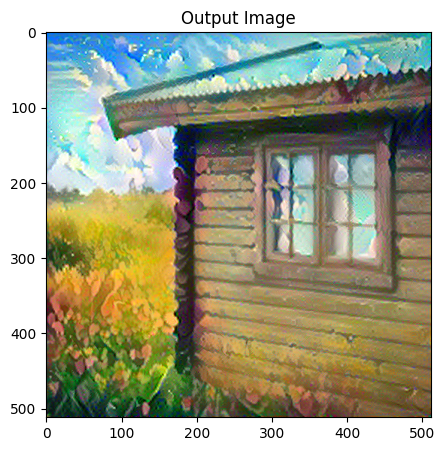

In [26]:
import os

def show_results_and_save(best_img, content_path, style_path, output_folder, show_large_final=True):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Load images
    content = load_img(content_path)
    style = load_img(style_path)

    # Plot the original content and style images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    imshow(content, 'Content Image')

    plt.subplot(1, 2, 2)
    imshow(style, 'Style Image')

    # Plot and save the output image
    if show_large_final:
        plt.figure(figsize=(5, 5))
        plt.imshow(best_img)
        plt.title('Output Image')

        # Save the output image to the specified folder
        output_path = os.path.join(output_folder, 'output_image.png')
        plt.savefig(output_path)

        plt.show()

# Example usage:
output_folder = '/content/output_images/'
show_results_and_save(best, content_path, style_path, output_folder)


In [37]:
'''
from PIL import Image
import numpy as np

def merge_and_save_images(image1_path, image2_path, image3, output_path):
    # Open the images
    image1 = Image.open(image1_path)
    image2 = Image.open(image2_path)

    # Handle image3 if it's a path or an image object
    if isinstance(image3, str):
        image3 = Image.open(image3)
    else:
        # Assume it's already an Image object
        pass

    # Ensure all images have the same size
    size = image1.size
    image2 = image2.resize(size)

    # Create a new copy of the NumPy array to avoid the resize error
    image3_array = np.copy(np.array(image3))
    image3 = Image.fromarray(image3_array).resize(size)

    # Create a new image with a width three times the original images
    merged_image = Image.new('RGB', (size[0] * 3, size[1]))

    # Paste the images side by side
    merged_image.paste(image1, (0, 0))
    merged_image.paste(image2, (size[0], 0))
    merged_image.paste(image3, (size[0] * 2, 0))

    # Save the result
    merged_image.save(output_path)

# Example usage:
output_path = '/content/output_images/merged_image.jpg'

merge_and_save_images(content_path, style_path, best, output_path)
'''

In [52]:
def merge_and_save_images(image1_path, image2_path, image3, output_folder, result_index):
    # Open the images
    image1 = Image.open(image1_path)
    image2 = Image.open(image2_path)

    # Handle image3 if it's a path or an image object
    if isinstance(image3, str):
        image3 = Image.open(image3)
    else:
        # Assume it's already an Image object
        pass

    # Ensure all images have the same size
    size = image1.size
    image2 = image2.resize(size)

    # Create a new copy of the NumPy array to avoid the resize error
    image3_array = np.copy(np.array(image3))
    image3 = Image.fromarray(image3_array).resize(size)

    # Create a new image with a width three times the original images
    merged_image = Image.new('RGB', (size[0] * 3, size[1]))

    # Paste the images side by side
    merged_image.paste(image1, (0, 0))
    merged_image.paste(image2, (size[0], 0))
    merged_image.paste(image3, (size[0] * 2, 0))

    # Save the result with a unique filename
    result_filename = f'result_{result_index}.jpg'
    output_path = os.path.join(output_folder, result_filename)
    merged_image.save(output_path)

# Example usage:
output_folder = '/content/output_images/'

In [46]:
content_images_dir = '/content'
style_images_dir = '/content/Style'
output_images_dir = '/content/output_images/'


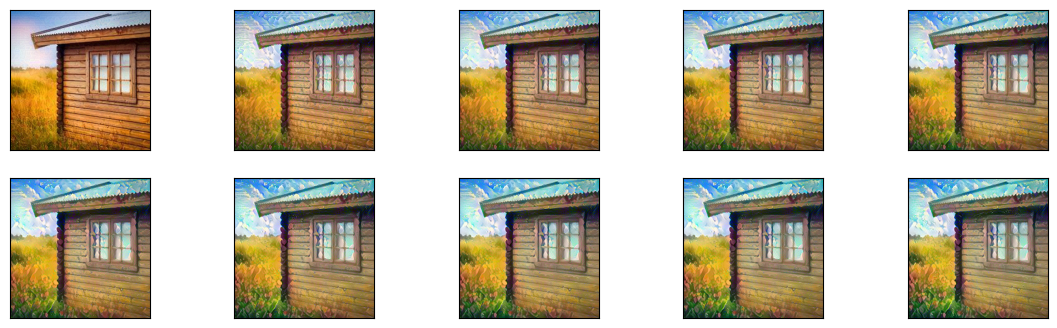

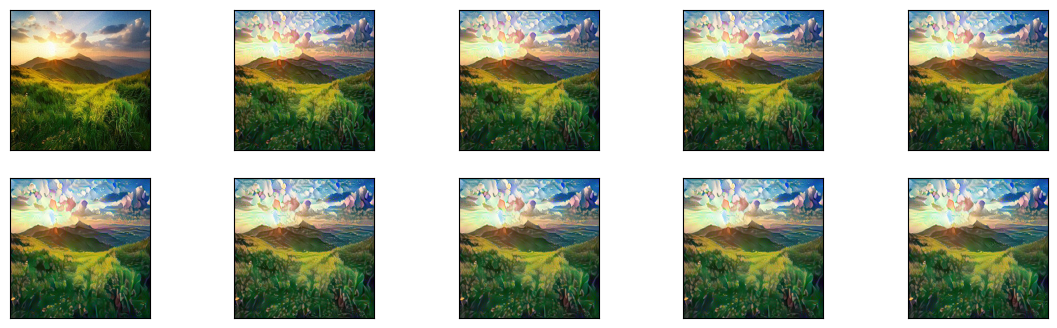

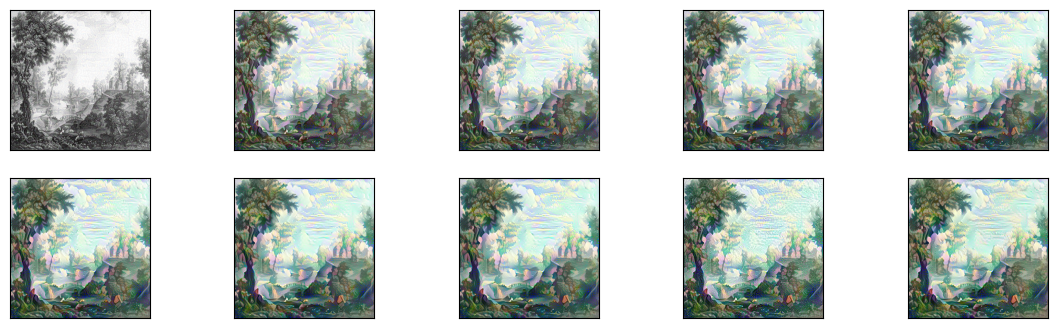

In [55]:
import os

# Create output directory if it doesn't exist
if not os.path.exists(output_images_dir):
    os.makedirs(output_images_dir)

# List all content image files
content_image_files = [f for f in os.listdir(content_images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
count=0
# Loop through each content image
for content_image_file in content_image_files:
    content_image_path = os.path.join(content_images_dir, content_image_file)

    # List all style image files
    style_image_files = [f for f in os.listdir(style_images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    count+=1
    # Loop through each style image
    for style_image_file in style_image_files:
        style_image_path = os.path.join(style_images_dir, style_image_file)

        # Define output path for the result
        result_image_name = f"{os.path.splitext(content_image_file)[0]}_{os.path.splitext(style_image_file)[0]}_result.jpg"
        result_image_path = os.path.join(output_images_dir, result_image_name)

        # Run style transfer for the current pair of content and style images
        best, best_loss = run_style_transfer(content_image_path, style_image_path, num_iterations=1000)

        # Save the result
    merge_and_save_images(content_path, '/content/Style/style.jpg', best, output_folder, result_index=count)
